# Exercise 2
Build a KNN model with your selected stock / market index using your best distance measure, determine the number attributes that is capable of giving the best prediction.
(Select attributes in ascending order(ie 3, 5, 7, ...) and determine the accuracy for the selected attributes, compare the accuracies to find which is the best)

In [1]:
import pandas as pd

pd.set_option('display.max_colwidth', None)
IBM = pd.read_csv('../Data/IBM.txt.zst', delimiter=' ', index_col='Date')
IBM.head(5)

,Open,High,Low,Close,Volume,Adjusted
Date,,,,,,
2007-01-03,97.180000,98.400002,96.260002,97.269997,9196800,63.127567
2007-01-04,97.250000,98.790001,96.879997,98.309998,10524500,63.802544
2007-01-05,97.599998,97.949997,96.910004,97.419998,7221300,63.224930
2007-01-08,98.500000,99.500000,98.349998,98.900002,10340000,64.185463
2007-01-09,99.080002,100.330002,99.070000,100.070000,11108200,64.944771


In [2]:
IBM.describe(include='all', datetime_is_numeric=True)

,Open,High,Low,Close,Volume,Adjusted
count,3692.000000,3692.000000,3692.000000,3692.000000,3.692000e+03,3692.000000
mean,147.198976,148.403180,146.074512,147.269085,5.576247e+06,113.375997
std,30.808862,30.780935,30.844083,30.796603,3.229710e+06,25.410689
min,72.739998,76.980003,69.500000,71.739998,1.027500e+06,48.040176
25%,124.189999,125.349998,123.072502,124.332496,3.482300e+06,90.296511
50%,144.750000,145.619995,143.830002,144.730003,4.653750e+06,120.980629
75%,168.847500,170.442501,167.659996,169.169998,6.660725e+06,132.155647
max,215.380005,215.899994,214.300003,215.800003,3.806350e+07,155.979538


First we compute the `Daily Returns` as according to the formular:
$r_{t+1} = \frac{p_{t+1} - p_t}{p_t}$

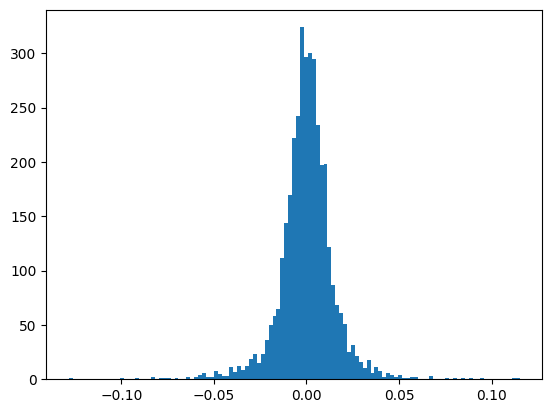

In [3]:
import numpy as np
import matplotlib.pyplot as plt

daily_returns = np.empty(IBM['Close'].shape)
daily_returns[0] = float('NaN')
daily_returns[1:] = np.ediff1d(IBM['Close']) / IBM['Close'][:-1]
IBM['Daily Returns'] = daily_returns

num_bins = int(len(daily_returns) / 32)
plt.hist(daily_returns, bins=num_bins)
plt.show()

Next we compute the `Binary Decision` (up/down) and the `Ternary decision` (up/flat/down).

In [4]:
binary_decision = (daily_returns > 0).astype(int)
IBM['Binary Decision'] = binary_decision

CUTOFF = 0.005
ternary_decision = np.full(shape=daily_returns.shape, fill_value=1)
ternary_decision[np.where(daily_returns > CUTOFF)] = 2
ternary_decision[np.where(daily_returns < CUTOFF)] = 0
IBM['Ternary Decision'] = ternary_decision

And we compute the simple moving average (SMA).

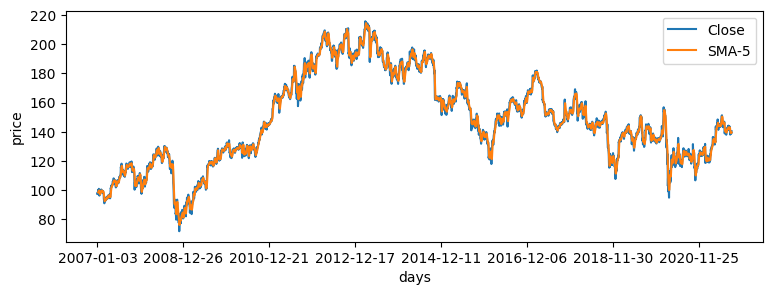

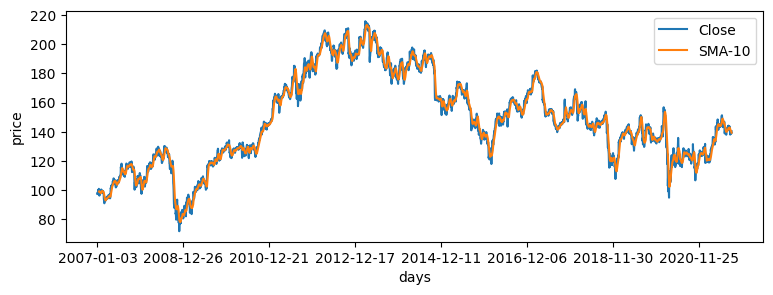

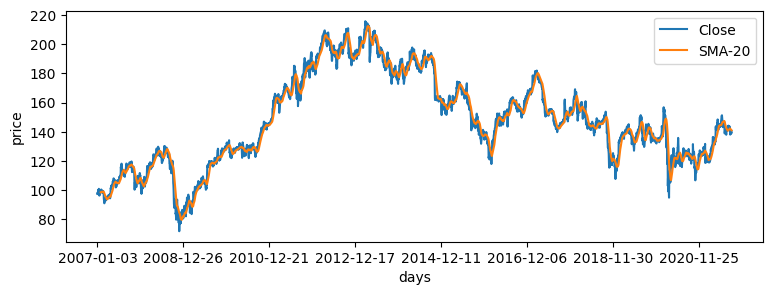

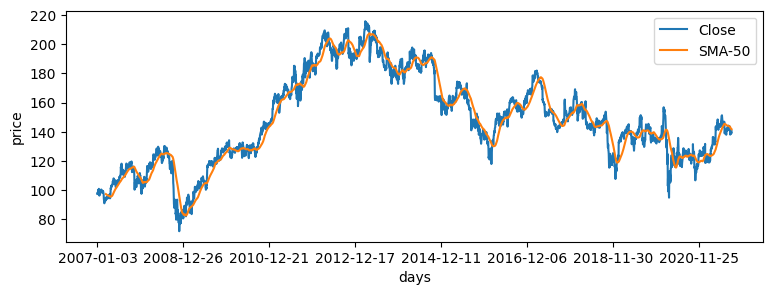

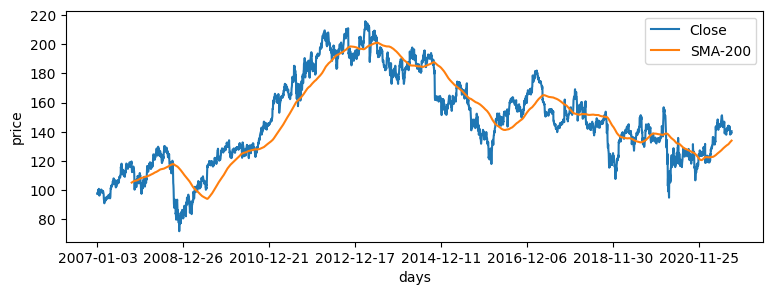

In [5]:
sma_features = []
for period in [5, 10, 20, 50, 200]:
    label = 'SMA-{}'.format(period)
    sma_features.append(label)

    IBM[label] = IBM['Close'].rolling(period).mean()
    IBM[['Close', label]].plot(label=label, figsize=(9, 3), xlabel='days', ylabel='price')

We replace all `NaN` with `0`.

In [6]:
IBM.fillna(0, inplace=True)
IBM.tail(5)

,Open,High,Low,Close,Volume,Adjusted,Daily Returns,Binary Decision,Ternary Decision,SMA-5,SMA-10,SMA-20,SMA-50,SMA-200
Date,,,,,,,,,,,,,,
2021-08-25,139.919998,140.800003,139.460007,139.860001,2012800,139.860001,0.000143,1,0,139.289999,140.817999,141.5470,142.2288,133.43165
2021-08-26,139.970001,140.800003,138.710007,138.779999,2498700,138.779999,-0.007722,0,0,139.441998,140.388998,141.3895,142.0478,133.54790
2021-08-27,138.710007,139.589996,138.399994,139.410004,2459500,139.410004,0.004540,1,0,139.501999,140.012000,141.3120,141.9240,133.65540
2021-08-30,139.500000,139.880005,138.820007,138.970001,1995500,138.970001,-0.003156,0,0,139.372000,139.550000,141.1895,141.8410,133.76425
2021-08-31,139.539993,140.940002,138.949997,140.339996,4233900,140.339996,0.009858,1,2,139.472000,139.342000,141.0030,141.7148,133.89345


In [7]:
metrics = ['manhattan', 'euclidean', 'cosine']
all_features = ['Open', 'Volume'] + sma_features

# taken from https://docs.scipy.org/doc/scipy/reference/spatial.distance.html#
other_metrics = ['braycurtis', 'canberra', 'chebyshev', 'correlation', 'minkowski', 'sqeuclidean', 'hamming']

We will test the K-NN accuracy on the target `Ternary Decision`.

In [8]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier


def knn_accuracy(features, metric):
    X = IBM[features]
    y = IBM['Ternary Decision']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=100 / IBM.shape[0], random_state=224, shuffle=False)

    knn = KNeighborsClassifier(metric=metric)
    knn.fit(X_train, y_train)

    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

In [9]:
def compute_accuracies(features, metrics) -> pd.DataFrame:
    accuracies = pd.DataFrame(
        map(lambda metric: [features, metric, knn_accuracy(features, metric)], metrics),
        columns=['Features', 'Metric', 'Accuracy'],
    ).sort_values(by='Accuracy', ascending=False)

    return accuracies

In [10]:
compute_accuracies(all_features, metrics)

,Features,Metric,Accuracy
2,"[Open, Volume, SMA-5, SMA-10, SMA-20, SMA-50, SMA-200]",cosine,0.63
0,"[Open, Volume, SMA-5, SMA-10, SMA-20, SMA-50, SMA-200]",manhattan,0.57
1,"[Open, Volume, SMA-5, SMA-10, SMA-20, SMA-50, SMA-200]",euclidean,0.57


In [11]:
compute_accuracies(all_features, other_metrics)

,Features,Metric,Accuracy
3,"[Open, Volume, SMA-5, SMA-10, SMA-20, SMA-50, SMA-200]",correlation,0.68
6,"[Open, Volume, SMA-5, SMA-10, SMA-20, SMA-50, SMA-200]",hamming,0.68
1,"[Open, Volume, SMA-5, SMA-10, SMA-20, SMA-50, SMA-200]",canberra,0.63
0,"[Open, Volume, SMA-5, SMA-10, SMA-20, SMA-50, SMA-200]",braycurtis,0.57
2,"[Open, Volume, SMA-5, SMA-10, SMA-20, SMA-50, SMA-200]",chebyshev,0.57
4,"[Open, Volume, SMA-5, SMA-10, SMA-20, SMA-50, SMA-200]",minkowski,0.57
5,"[Open, Volume, SMA-5, SMA-10, SMA-20, SMA-50, SMA-200]",sqeuclidean,0.57


We define a simple function to create an iterable over all possible feature combinations.

In [12]:
from itertools import combinations

def all_combinations():
    for i in range(1, len(all_features)):
        list_of_features = [list(comb) for comb in combinations(all_features, i)]
        for features in list_of_features:
            yield features

In [13]:
def compute_best_accuracies(metrics) -> pd.DataFrame:
    accuracies = pd.DataFrame(
        map(lambda m: max(map(lambda c: [m, c, knn_accuracy(c, m)], all_combinations()), key=lambda k: k[2]), metrics),
        columns=['Metric', 'Feature Combination', 'Accuracy'],
    ).sort_values(by='Accuracy', ascending=False)

    return accuracies

In [14]:
compute_best_accuracies(metrics)

,Metric,Feature Combination,Accuracy
0,manhattan,"[Open, SMA-5, SMA-10, SMA-50]",0.72
1,euclidean,"[SMA-10, SMA-50]",0.71
2,cosine,"[SMA-5, SMA-10, SMA-50, SMA-200]",0.71


In [15]:
compute_best_accuracies(other_metrics)

,Metric,Feature Combination,Accuracy
0,braycurtis,"[Open, SMA-5, SMA-10, SMA-50]",0.72
1,canberra,"[Open, SMA-5, SMA-10, SMA-50]",0.72
3,correlation,"[Volume, SMA-5, SMA-10, SMA-50]",0.72
2,chebyshev,"[SMA-10, SMA-50]",0.71
4,minkowski,"[SMA-10, SMA-50]",0.71
5,sqeuclidean,"[SMA-10, SMA-50]",0.71
6,hamming,[Volume],0.68
